# Decision Making Model

In [8]:
pip install brainpy-simulator

In [9]:
import numpy as np
import brainpy as bp

import matplotlib.pyplot as plt
from collections import OrderedDict

bp.backend.set('numba', dt=0.0005)

## A rate model for decision-making

Consider two excitatory neural assemblies, populations $1$ and $2$, that compete with each other through a shared pool of 
inhibitory neurons.

![](https://github.com/cahcharm/Neuro-and-Complexity-Science/blob/CSHA2021/tutorials/Computational%20Neuroscience/network_model/files/decision_model.png?raw=1)


Let $r_1$ and $r_2$ be their respective population-firing rates, and the total synaptic input current $I_i$ and the resulting firing rate $r_i$ of the neural population $i$ obey the following input-output relationship ($F - I$ curve):

$$
r_i = F(I_i) = \frac{aI_i - b}{1-\exp(-d(aI_i-b))}
$$

which captures the current-frequency function of a leaky integrate-and-fire neuron. The parameter values are $a$ = 270 Hz/nA, $b$ = 108 Hz, $d$ = 0.154 sec.

Assume that the 'synaptic drive variables' $S_1$ and $S_2$ obey

\begin{align}
\frac{dS_1}{dt} &= F(I_1)\,\gamma(1-S_1)-S_1/\tau_s\\
\frac{dS_2}{dt} &= F(I_2)\,\gamma(1-S_2)-S_2/\tau_s
\end{align}

where $\gamma$ = 0.641. The net current into each population is given by 

\begin{align}
I_1 &= J_E S_1 + J_I S_2 + I_{b1} + J_{ext}\mu_1\\
I_2 &= J_E S_2 + J_I S_1 +I_{b2} +J_{ext}\mu_2.
\end{align}


The synaptic time constant is $\tau_s$ = 100 ms (NMDA time consant). The synaptic coupling strengths are $J_E$ = 0.2609 nA, $J_I$ = -0.0497 nA, and $J_{ext}$ = 0.00052 nA. Stimulus-selective inputs to populations 1 and 2 are governed by unitless parameters $\mu_1$ and $\mu_2$, respectively. $I_b$ is the background input which has a mean $I_0$ and a noise component described by an Ornstein-Uhlenbeck process:

\begin{align}
dI_{b1} &= (I_0 - I_{b1}) \frac{dt}{\tau_0} + \sigma dW \\
dI_{b2} &= (I_0 - I_{b2}) \frac{dt}{\tau_0} + \sigma dW \\
\end{align}

where $I_0=0.3255$ nA, filter time constant $\tau_0=2$ ms, and noise amplitude $\sigma=0.02$ nA. $dW$ is a Wiener process and note that when numerially integrating that with step size $\frac{dt}{\tau_0}$ then $\Delta W \sim \mathcal{N}(0, \frac{dt}{\tau_0})$, a normal distribution with mean 0 and variance $\frac{dt}{\tau_0}$

For the decision-making paradigm, the input rates $\mu_1$ and $\mu_2$ are determined by the stimulus coherence $c'$ which ranges between 0 (0%) and 1 (100%):

\begin{align}
\mu_1 &=\mu_0(1+c')\\
\mu_2 &=\mu_0(1-c')
\end{align}

**References:**

- Wong K-F and Wang X-J (2006). A recurrent network mechanism for time integration in perceptual decisions. J. Neurosci 26, 1314-1328.

## Implementation

In [10]:
gamma = 0.641 # Saturation factor for gating variable
tau = 0.06 # Synaptic time constant [sec]
tau0 = 0.002 # Noise time constant [sec]
a = 270.
b = 108.
d = 0.154

I0 = 0.3255 # background current [nA]
JE = 0.3725  # self-coupling strength [nA]
JI = -0.1137  # cross-coupling strength [nA]
JAext = 0.00117  # Stimulus input strength [nA]
sigma = 1.02 # nA

# I0 = 0.3255 # background current [nA]
# JE = 0.2609  # self-coupling strength [nA]
# JI = -0.0497  # cross-coupling strength [nA]
# JAext = 5.2e-4  # Stimulus input strength [nA]
# sigma = 0.02 # nA


In [13]:
class DecisionMaking(bp.NeuGroup):
    target_backend = ['numpy', 'numba']
    
    @staticmethod
    def current2rate(I):
      return (a * I - b) / (1. - np.exp(-d * (a * I - b)))

    @staticmethod
    @bp.odeint
    def integral(s1, s2, t, mu0, coh, Ib1, Ib2):
      mu1 = mu0 * (1 + coh)
      mu2 = mu0 * (1 - coh)
      I1 = JE * s1 + JI * s2 + Ib1 + JAext * mu1
      I2 = JE * s2 + JI * s1 + Ib2 + JAext * mu2 
      r1 = (a * I1 - b) / (1. - np.exp(-d * (a * I1 - b)))
      r2 = (a * I2 - b) / (1. - np.exp(-d * (a * I2 - b)))
      ds1dt = - s1 / tau + r1 * gamma * (1 - s1)
      ds2dt = - s2 / tau + r2 * gamma * (1 - s2)
      return ds1dt, ds2dt
    
    @staticmethod
    @bp.odeint
    def int_noise(Ib1, Ib2, t, sigma):
      dIb1 = (I0 - Ib1) / tau0 + sigma / tau0 * np.random.randn(*Ib1.shape)
      dIb2 = (I0 - Ib2) / tau0 + sigma / tau0 * np.random.randn(*Ib2.shape)
      return dIb1, dIb2
    
    def __init__(self, size, **kwargs):
      super(DecisionMaking, self).__init__(size=size, **kwargs)
      
      # parameters
      self.mu0 = 20. # Stimulus firing rate [spikes/sec]
      self.coh = 0.2  # # Stimulus coherence [%]
      self.sigma = 0.02 # nA

      # variables
      self.s1 = np.zeros(self.num)
      self.s2 = np.zeros(self.num)
      self.Ib1 = np.zeros(self.num)
      self.Ib2 = np.zeros(self.num)

    def update(self, _t):
      self.s1, self.s2 = self.integral(self.s1, self.s2, _t, 
                                        self.mu0, self.coh,
                                        self.Ib1, self.Ib2)
      self.Ib1, self.Ib2 = self.int_noise(self.Ib1, self.Ib2, _t, self.sigma)

## Analysis

$\mu_0 = 0, c'=0.$

plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.061761092155827105, s1=0.061761097890626476 is a stable node.
Fixed point #2 at s2=0.029354239099992224, s1=0.18815448592734063 is a saddle node.
Fixed point #3 at s2=0.004246842370236147, s1=0.6303045696241586 is a stable node.
Fixed point #4 at s2=0.6303045696241566, s1=0.004246842370237166 is a stable node.
Fixed point #5 at s2=0.1881543994457495, s1=0.02935424053669559 is a saddle node.
plot vector field ...


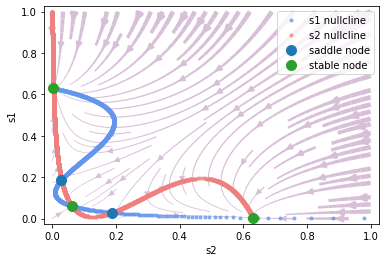

In [14]:
phase = bp.analysis.PhasePlane(DecisionMaking.integral,
                               target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
                               pars_update=dict(mu0=0., coh=0., Ib1=0.3297, Ib2=0.3297),
                               numerical_resolution=0.0005,
                               options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
res = phase.plot_vector_field()

$\mu_0 = 30, c'=0.$

plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.6993504413889293, s1=0.011622049526590685 is a stable node.
Fixed point #2 at s2=0.49867489858361147, s1=0.49867489858361147 is a saddle node.
Fixed point #3 at s2=0.011622051540013556, s1=0.699350435552933 is a stable node.
plot vector field ...


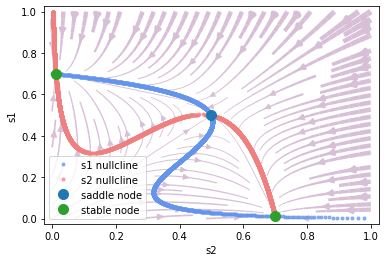

In [16]:
phase = bp.analysis.PhasePlane(DecisionMaking.integral,
                               target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
                               pars_update=dict(mu0=30, coh=0, Ib1=0.3297, Ib2=0.3297),
                               numerical_resolution=0.0003,
                               options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
res = phase.plot_vector_field()

$\mu_0 = 30, c'=0.5$

plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.6665760402553582, s1=0.02719640035980428 is a stable node.
Fixed point #2 at s2=0.5669187077798463, s1=0.29070648401832583 is a saddle node.
Fixed point #3 at s2=0.0054926536673984405, s1=0.7226555647909328 is a stable node.
plot vector field ...


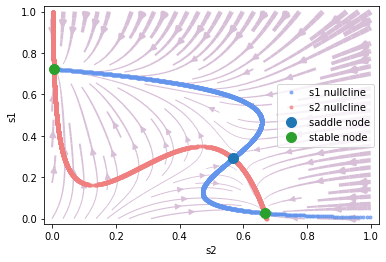

In [17]:
phase = bp.analysis.PhasePlane(DecisionMaking.integral,
                               target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
                               pars_update=dict(mu0=30, coh=0.5, Ib1=0.3297, Ib2=0.3297),
                               numerical_resolution=0.0003,
                               options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
res = phase.plot_vector_field()

$\mu_0 = 30, c'=-0.5$

plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.29070649861020886, s1=0.5669187045884816 is a saddle node.
Fixed point #2 at s2=0.02719640035987484, s1=0.6665760402553137 is a stable node.
Fixed point #3 at s2=0.7226555647909357, s1=0.005492653667400048 is a stable node.
plot vector field ...


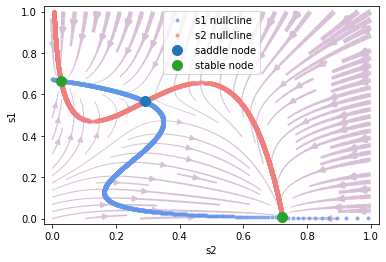

In [18]:
phase = bp.analysis.PhasePlane(DecisionMaking.integral,
                               target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
                               pars_update=dict(mu0=30, coh=-0.5, Ib1=0.3297, Ib2=0.3297),
                               numerical_resolution=0.0003,
                               options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
res = phase.plot_vector_field()

$\mu_0 = 30, c'=1.$

plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.0026865954386732244, s1=0.7410985604497796 is a stable node.
plot vector field ...


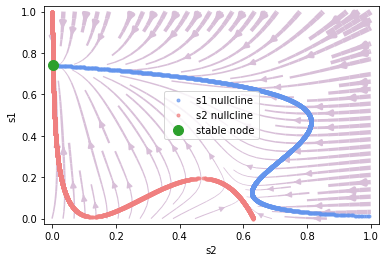

In [19]:
phase = bp.analysis.PhasePlane(DecisionMaking.integral,
                               target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
                               pars_update=dict(mu0=30, coh=1, Ib1=0.3297, Ib2=0.3297),
                               numerical_resolution=0.0003,
                               options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
res = phase.plot_vector_field()